###  MicroGrad demo

In [612]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

%matplotlib inline

In [613]:
np.random.seed(1337)
random.seed(1337)

In [614]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n._name, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [615]:
# Загрузка данных MNIST
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

# Преобразование данных в формат float32
X_train = X_train.astype('float64') / 255.0 * 2 - 1
X_test = X_test.astype('float64') / 255.0 * 2 - 1

# Изменение формы данных
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

# One-hot кодирование меток
# y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=10)
# y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=10)

# y_train_oh

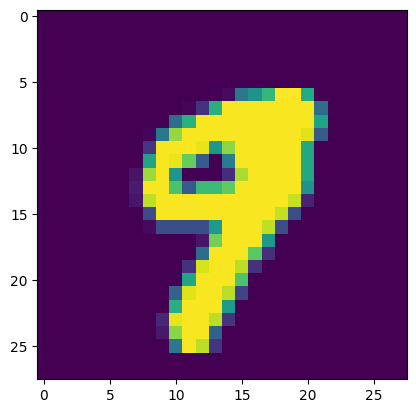

In [616]:
def draw_some(numbers):
    number = numbers[random.randint(0, numbers.shape[0] - 1)]
    plt.imshow(number.reshape([28, 28]))

draw_some(X_train)

In [617]:
from collections import defaultdict

POSITIVE_CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def oh_encode(y, classes):
    NEG = -1.0
    POS = 1.0

    noise = np.array([NEG] * len(classes))

    oh_enc = defaultdict(lambda: noise)
    oh_dec = defaultdict(lambda: None)

    for i, cls in enumerate(classes):
        cls_vec = np.array([NEG] * len(classes))
        cls_vec[i] = POS
        oh_enc[cls] = cls_vec
        oh_dec[tuple(cls_vec)] = cls

    def oh_decode(values):
        # pick the closest vector (is round() OK for that?)
        encoded = tuple(np.array([v.data for v in values]).round())
        return oh_dec[encoded]

    return oh_decode, np.array([oh_enc[cls] for cls in y])

In [618]:
def get_batch(X, Y_oh, batch_size):
    ri = np.random.permutation(X.shape[0])[:batch_size]
    X, Y_oh = X[ri], Y_oh[ri]
    return X, Y_oh


def arr2vals(array, name):
    return [[Value(el, _name=name) for el in row] for row in array]


def batch2vals(batch):
    return tuple(map(arr2vals, batch))

In [619]:
def accuracy(scores, ground_truths):
    matches = 0
    for score, ground_truths in zip(scores, ground_truths):
        matches += OH_DECODER(score) == OH_DECODER(ground_truths)

    return matches / len(scores)


def one_loss(score, ground_truth):
    return sum((s - gt)**2 for s, gt in zip(score, ground_truth))


def loss(scores, Y_oh):
    return sum(one_loss(xs, ys) for xs, ys in zip(scores, Y_oh))


def feed_forward(model, X):
    return list(map(model, X))


def evaluate(model, X_b, Y_b):
    input = arr2vals(X_b, 'input')
    scores = feed_forward(model, input)
    expected = arr2vals(Y_b, 'expected')
    return loss(scores, expected), accuracy(scores, expected)

In [620]:
# initialize a model
model = MLP(
    784,
    [
        (10, 'xspace'),
        (10, 'xspace')
    ],
    lr=1.0
)
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [xspace-Neuron(784), xspace-Neuron(784), xspace-Neuron(784), xspace-Neuron(784), xspace-Neuron(784), xspace-Neuron(784), xspace-Neuron(784), xspace-Neuron(784), xspace-Neuron(784), xspace-Neuron(784)], Layer of [xspace-Neuron(10), xspace-Neuron(10), xspace-Neuron(10), xspace-Neuron(10), xspace-Neuron(10), xspace-Neuron(10), xspace-Neuron(10), xspace-Neuron(10), xspace-Neuron(10), xspace-Neuron(10)]]
number of parameters 7960


In [635]:
from copy import deepcopy

def frozen_neurons():
    return [
        deepcopy(neuron)
        for neuron in (
            NEURON_0,
            NEURON_1,
            NEURON_2,
            NEURON_3,
            NEURON_4,
            NEURON_5,
            NEURON_6,
            NEURON_7,
            NEURON_8,
            NEURON_9
        )
    ]

def freeze_layer_0(model):
    model.layers[0].neurons = frozen_neurons()
    for p in model.layers[0].parameters():
        p._lr = 0.0

def norm_layers(model):
    for layer in model.layers:
        for neuron in layer.neurons:
            norm = sum(abs(p.data) for p in neuron.parameters())
            for p in neuron.parameters():
                p.data /= norm

In [622]:
# select positives
SELECT_CLASSES = [9]

def select(X, Y, selector):
    idx = np.where(np.isin(Y, selector))[0]
    return X[idx], Y[idx]

# X_train, Y_train = select(X_train, Y_train, SELECT_CLASSES)

OH_DECODER, Y_oh = oh_encode(Y_train, POSITIVE_CLASSES)
_, Y_t_oh = oh_encode(Y_test, POSITIVE_CLASSES)

Y_oh.shape

(60000, 10)

start: loss 32.0, accuracy 0.0%


(Value(auto : [32.0, 0.0]), 0.0, [5])

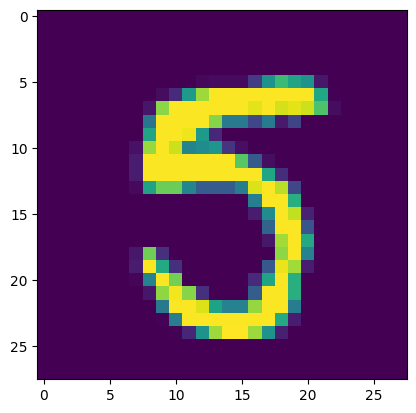

In [638]:
# sample batch
BATCH_SIZE = 1
X_b, Y_b = get_batch(X_train, Y_oh, BATCH_SIZE)
X_b.shape

freeze_layer_0(model); norm_layers(model);  # todo: remove me

total_loss, acc = evaluate(model, X_b, Y_b)
print(f"start: loss {total_loss.data}, accuracy {acc*100}%")

draw_some(X_b)
total_loss, acc, [OH_DECODER(vs) for vs in arr2vals(Y_b, 'expected')][:20]

In [624]:
# train the model
ITERATIONS = 5

# total_loss, acc = evaluate(model, X_b, Y_b)
# print(f"start: loss {total_loss.data}, accuracy {acc*100}%")

# optimization loop
for k in range(ITERATIONS):
    if total_loss.data == 0:
        print(f"step {k}: loss {total_loss.data}, accuracy {acc*100}%")
        print("Early stop!")
        break

    model.learn_from(total_loss)
    norm_layers(model)

    total_loss, acc = evaluate(model, X_b, Y_b)
    print(f"step {k}: loss {total_loss.data}, accuracy {acc*100}%")

# total_loss, acc = evaluate(model, X_b, Y_b)
# print(f"final loss {total_loss.data}, total accuracy {acc*100}%")

step 0: loss 8.0, accuracy 0.0%
step 1: loss 8.0, accuracy 0.0%
step 2: loss 1.232595164407831e-32, accuracy 100.0%
step 3: loss 1.232595164407831e-32, accuracy 100.0%
step 4: loss 2.465190328815662e-32, accuracy 100.0%


# DEBUG

In [650]:
import numpy as np

frozen_parameters = np.array([[p.data for p in n.parameters()] for n in model.layers[0].neurons])
# np.save('mnist_parameters_10x785_positives.npy', frozen_parameters)
frozen_parameters # just set learning rate to 0.0

array([[ 0.00165801,  0.00165801,  0.00165802, ...,  0.00165982,
         0.00165982, -0.00165801],
       [ 0.00142843,  0.00142301,  0.00141952, ...,  0.0014286 ,
         0.00141208, -0.00141792],
       [ 0.00170784,  0.00170289,  0.0016997 , ...,  0.001708  ,
         0.00169289, -0.00169823],
       ...,
       [ 0.00156875,  0.00155558,  0.0015471 , ...,  0.00156916,
         0.00152902, -0.00154322],
       [ 0.00175211,  0.00170941,  0.00168191, ...,  0.00175344,
         0.00162328, -0.00166933],
       [-0.00130701, -0.0013611 , -0.00139594, ..., -0.00130532,
        -0.00147021,  0.00141188]])

In [508]:
LAYER = 0

# NEURON_0 = model.layers[LAYER].neurons[0]
# NEURON_1 = model.layers[LAYER].neurons[0]
# NEURON_2 = model.layers[LAYER].neurons[0]
# NEURON_3 = model.layers[LAYER].neurons[0]
# NEURON_4 = model.layers[LAYER].neurons[0]
# NEURON_5 = model.layers[LAYER].neurons[0]
# NEURON_6 = model.layers[LAYER].neurons[0]
# NEURON_7 = model.layers[LAYER].neurons[0]
# NEURON_8 = model.layers[LAYER].neurons[0]
# NEURON_9 = model.layers[LAYER].neurons[0]

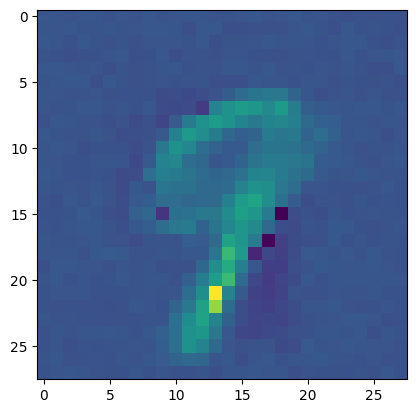

In [649]:
w = np.array([p.data for p in model.layers[0].neurons[9].parameters()][:-1])
w = w.reshape([-1, w.shape[0]])
draw_some(w)

In [416]:
# X_t, Y_t = get_batch(X_test, Y_t_oh, BATCH_SIZE)
X_t, Y_t = X_b, Y_b

input = arr2vals(X_t, 'input')
expected = arr2vals(Y_t, 'expected')
scores = feed_forward(model, input)

for a, e in zip(scores, expected):
    a, e = OH_DECODER(a), OH_DECODER(e)
    op = '=' if a == e else '!='
    print(f'actual: {a} {op} expected: {e}')

actual: 9 = expected: 9


In [417]:
scores

[[Value(auto : [-1.0, 0.0]),
  Value(auto : [-1.0, 0.0]),
  Value(auto : [-1.0, 0.0]),
  Value(auto : [-1.0, 0.0]),
  Value(auto : [-1.0, 0.0]),
  Value(auto : [-1.0, 0.0]),
  Value(auto : [-1.0, 0.0]),
  Value(auto : [-1.0, 0.0]),
  Value(auto : [-1.0, 0.0]),
  Value(auto : [1.0, 0.0])]]

In [418]:
expected

[[Value(expected : [-1.0, 0.0]),
  Value(expected : [-1.0, 0.0]),
  Value(expected : [-1.0, 0.0]),
  Value(expected : [-1.0, 0.0]),
  Value(expected : [-1.0, 0.0]),
  Value(expected : [-1.0, 0.0]),
  Value(expected : [-1.0, 0.0]),
  Value(expected : [-1.0, 0.0]),
  Value(expected : [-1.0, 0.0]),
  Value(expected : [1.0, 0.0])]]

In [419]:
total_loss = loss(scores, expected)
total_loss.backward()
total_loss

Value(auto : [0.0, 1])

In [420]:
parameters = [p for p in model.layers[1].parameters() if p.grad > 0.0]
parameters.sort(key=lambda p: p._lr)
[p._lr for p in parameters]

[128.0, 128.0, 128.0, 128.0, 128.0, 128.0, 128.0, 128.0]